In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, scale
from Research.config import GOOGLE_API_KEY # You will need your own API key
import google.generativeai as genai

# Function involved in pipeline
def time_series(values1, time1, values2, time2, scaling=True, tscaling=True):
    '''
    Provides a scaled data frame of data from a simulation of a problem.

    :param values1: Dictionary of orbital values for the first dataset
    :param time1: An array of time for the first dataset
    :param values2: Dictionary of orbital values for the second dataset
    :param time2: An array of time for the second dataset
    :param scaling: Boolean value of orbital value standardization scaling
    :param tscaling: Boolean value of time array normalization scaling
    :return: Tuple of two DataFrames (df1, df2) with scaled orbital values and time
    '''

    # First, create a dataframe of the values.
    df1 = pd.DataFrame(values1)
    df2 = pd.DataFrame(values2)
    
    # Add the time values to the Dataframe.
    df1['Time'] = time1
    df2['Time'] = time2
    
    # If scaling for data is True, then apply scaling
    if scaling:
        # Combine the DataFrames temporarily 
        # This ensures scaling is centered around the same mean for comparability.
        data_combined = pd.concat([df1, df2], ignore_index=True)

        # Standardized values in the combined data.
        for column in data_combined.columns:
            # Do not Standardized time, we only want to normalize it later.
            if column != 'Time':
                # Apply Standardization (zero mean, unit variance)
                data_combined[column] = scale(data_combined[column], axis=0)

        # Split back to original DataFrames.
        df1_scaled = data_combined.iloc[:len(df1)].copy()
        df2_scaled = data_combined.iloc[len(df1):].copy()
        
        # Reset dataframe's index that got split due to the concatenation
        df2_scaled = df2_scaled.reset_index(drop=True)

        # Update the old data frames with the new scaled values
        df1.update(df1_scaled)
        df2.update(df2_scaled)


    # If tscaling is set to True, normalize the time values in the dataframes.     
    if tscaling:
        # We need to fit the normalization to the dataframe with the highest time value.
        if df1['Time'].max() >= df2['Time'].max():
            # Fit the MinMaxScaler on the dataframe with the highest time value (df1).
            scaler = MinMaxScaler()
            df1['Time'] = scaler.fit_transform(df1[['Time']])
            
            # Transform the second time array (df2) using the same scaler.
            df2['Time'] = scaler.transform(df2[['Time']])

        else: 
            scaler = MinMaxScaler()
            # Fit the MinMaxScaler on the dataframe with the highest time value (df2).
            df2['Time'] = scaler.fit_transform(df2[['Time']])
            
            # Transform the first time array (df1) using the same scaler.
            df1['Time'] = scaler.transform(df1[['Time']])

    return df1, df2  # Return both DataFrames

# Density of time points may change in a simulation - could be tricky to 
# make the time-series truly generic with adaptive timesteps in simulations.
def interpolate_data(ref_df, ai_df):
    '''
    Interpolates the orbital element data in the DataFrame to match the 
    reference time array using forward filling.

    :param ref_df: Dataframe with reference solution values.
    :param ai_df: Dataframe with AI data values.
    :return: A DataFrame with interpolated data.
    '''

    # Set index to the time column for interpolation.
    ref_df.set_index('Time', inplace=True)
    ai_df.set_index('Time', inplace=True)

    # Make sure Ref data, AI data is sorted by Time.
    ref_df = ref_df.sort_values(by='Time')
    ai_df = ai_df.sort_values(by='Time')

    if ai_df.shape[0] <= ref_df.shape[0]:

        # Merge the two data frames with reference on the left and AI data on the right.
        # Use forward filling to align data points.
        merged_df = pd.merge_asof(ref_df, ai_df, on='Time', suffixes=('_ref', '_ai'), direction='nearest')

        # Interpolate the orbital element columns using polynomial interpolation
        for col in merged_df.columns:
            if col != 'Time':
                # Interpolate the right side of the merged dataframe to the left side
                merged_df[col] = merged_df[col].interpolate(method='polynomial',order=5)

        # Split the merged dataframe to acquire the interpolated reference data
        ai_df_interpolated = pd.DataFrame()
        for col in ai_df.reset_index().columns:
           if col != 'Time':
               ai_df_interpolated[col] = merged_df[col+'_ai']
           else:
               ai_df_interpolated[col] = merged_df[col]
        # Return data, making sure we reset the index of the AI data set
        return ref_df.reset_index(), ai_df_interpolated

    elif ai_df.shape[0] >= ref_df.shape[0]:

        # Merge the two data frames with AI on the left and reference data on the right
        # Use nearest neighbor interpolation for potential higher accuracy.
        merged_df = pd.merge_asof(ai_df, ref_df, on='Time', suffixes=('_ai', '_ref'), direction='nearest')
        
        # Interpolate the orbital element columns using polynomial interpolation
        for col in merged_df.columns:
            if col != 'Time':
                # Interpolate the right side of the merged dataframe to the left side
                merged_df[col] = merged_df[col].interpolate(method='polynomial',order=5)

        # Split the merged dataframe to acquire the interpolated reference data
        ref_df_interpolated = pd.DataFrame()
        for col in ref_df.reset_index().columns:
           if col != 'Time':
               ref_df_interpolated[col] = merged_df[col+'_ref']
           else:
               ref_df_interpolated[col] = merged_df[col]
        # Return data, making sure we reset the index of the AI data set
        return ref_df_interpolated, ai_df.reset_index()
    

def compute_score(ref_df, ai_df, tot_rmse=False):
  '''
  Calculates the Root Mean Squared Error (RMSE) between two DataFrames,
  excluding the 'time' column.
  
  :param ref_df: Reference dataframe from solution of problem.
  :param ai_df: Dataframe from AI's solution of problem.
  :param tot_rmse: Boolean to calculate total RMSE across all columns
  :return: a single floating-point number (total RMSE) or a Series of RMSE values for each column.
  '''
  
  # Select only the columns with orbital data (exclude 'time')
  data_columns = [col for col in ref_df.columns if col != 'Time']

  # Calculate squared errors for the selected columns
  squared_errors = (ref_df[data_columns] - ai_df[data_columns])**2  

  # Calculate RMSE for each shared column
  rmse_values = np.sqrt(squared_errors.mean())
  
  if tot_rmse:
        # Calculate total RMSE by taking RMSE of individual RMSEs for each column
        total_rmse = np.sqrt(rmse_values.mean())  
        return total_rmse
  
  else:
      # Return RMSE values as a Series 
      return rmse_values
  
#Example begins here.

# Set up google AI
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel(model_name="gemini-1.5-pro") 

# Prompt example for Inclined Orbit (20degrees)
prompt = '''Provide Python code that utilizes the latest version of the Python package REBOUND N-body integrator to simulate a planetary system with a central star of 1 solar mass and three planets: a terrestrial planet with a mass of 0.8 Earth masses at 0.8 AU and eccentricity 0.02 (all other orbital elements are 0), an inclined planet with a mass of 1.6 Earth masses at 1.2 AU, with eccentricity of 0.01 and an inclination of 75 degrees (all other orbital elements are 0), and a gas giant with a mass of 80 Earth masses at 9.5 AU and eccentricity of 0.05 (all other orbital elements are 0).  Integrate the simulation for 20 periods of the inclined planet and track the inclination and semi-major axis for each planet as the simulation progresses, storing these values in a dictionary and tracking the simulation time in an array. Do not plot these values. Store the dictionary as follows:

	quantities = {'Terrestrial Planet Inclination':[],'Terrestrial Planet Semi-Major Axis':[],
	'Inclined Planet Inclination':[],'Inclined Planet Semi-Major Axis':[],
	'Gas Giant Inclination':[],'Gas Giant Semi-Major Axis':[]}
	
And store time in a normal array. Only return the dictionary and time array. Only provide the code, do not execute it in this environment.'''

#Excute code and copy and paste
response = model.generate_content(prompt,tools = 'code_execution')
print(response.text)

```python
import rebound
import numpy as np

# Define masses in solar masses
m_earth = 3e-6 # Earth mass in solar masses
m_star = 1.0

# Define orbital parameters
planets = [
    {'mass': 0.8 * m_earth, 'a': 0.8, 'e': 0.02, 'inc': 0.0, 'omega': 0.0, 'Omega': 0.0, 'M': 0.0},  # Terrestrial
    {'mass': 1.6 * m_earth, 'a': 1.2, 'e': 0.01, 'inc': np.radians(75.0), 'omega': 0.0, 'Omega': 0.0, 'M': 0.0},  # Inclined
    {'mass': 80.0 * m_earth, 'a': 9.5, 'e': 0.05, 'inc': 0.0, 'omega': 0.0, 'Omega': 0.0, 'M': 0.0}  # Gas giant
]

# Initialize simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m=m_star)  # Add central star

# Add planets
for planet in planets:
    sim.add(m=planet['mass'], a=planet['a'], e=planet['e'], inc=planet['inc'], omega=planet['omega'], Omega=planet['Omega'], M=planet['M'])

# Integration time (20 periods of the inclined planet)
period_inclined = sim.particles[2].P #calculates the period of the inclined planet using rebound
t_final = 20.0 *

In [20]:
import rebound
import numpy as np

# Define masses in solar masses
m_earth = 3e-6 # Earth mass in solar masses
m_star = 1.0

# Define orbital parameters
planets = [
    {'mass': 0.8 * m_earth, 'a': 0.8, 'e': 0.02, 'inc': 0.0, 'omega': 0.0, 'Omega': 0.0, 'M': 0.0},  # Terrestrial
    {'mass': 1.6 * m_earth, 'a': 1.2, 'e': 0.01, 'inc': np.radians(75.0), 'omega': 0.0, 'Omega': 0.0, 'M': 0.0},  # Inclined
    {'mass': 80.0 * m_earth, 'a': 9.5, 'e': 0.05, 'inc': 0.0, 'omega': 0.0, 'Omega': 0.0, 'M': 0.0}  # Gas giant
]

# Initialize simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
sim.add(m=m_star)  # Add central star

# Add planets
for planet in planets:
    sim.add(m=planet['mass'], a=planet['a'], e=planet['e'], inc=planet['inc'], omega=planet['omega'], Omega=planet['Omega'], M=planet['M'])

# Integration time (20 periods of the inclined planet)
period_inclined = sim.particles[2].P #calculates the period of the inclined planet using rebound
t_final = 20.0 * period_inclined

# Initialize data storage
quantities = {'Terrestrial Planet Inclination': [], 'Terrestrial Planet Semi-Major Axis': [],
              'Inclined Planet Inclination': [], 'Inclined Planet Semi-Major Axis': [],
              'Gas Giant Inclination': [], 'Gas Giant Semi-Major Axis': []}
times = []

# Integrate and store data
N_outputs=10000 # number of data points to store
t=0
while t < t_final:
  sim.integrate(t)
  times.append(t)
  quantities['Terrestrial Planet Inclination'].append(sim.particles[1].inc)
  quantities['Terrestrial Planet Semi-Major Axis'].append(sim.particles[1].a)
  quantities['Inclined Planet Inclination'].append(sim.particles[2].inc)
  quantities['Inclined Planet Semi-Major Axis'].append(sim.particles[2].a)
  quantities['Gas Giant Inclination'].append(sim.particles[3].inc)
  quantities['Gas Giant Semi-Major Axis'].append(sim.particles[3].a)
  t+=t_final/N_outputs


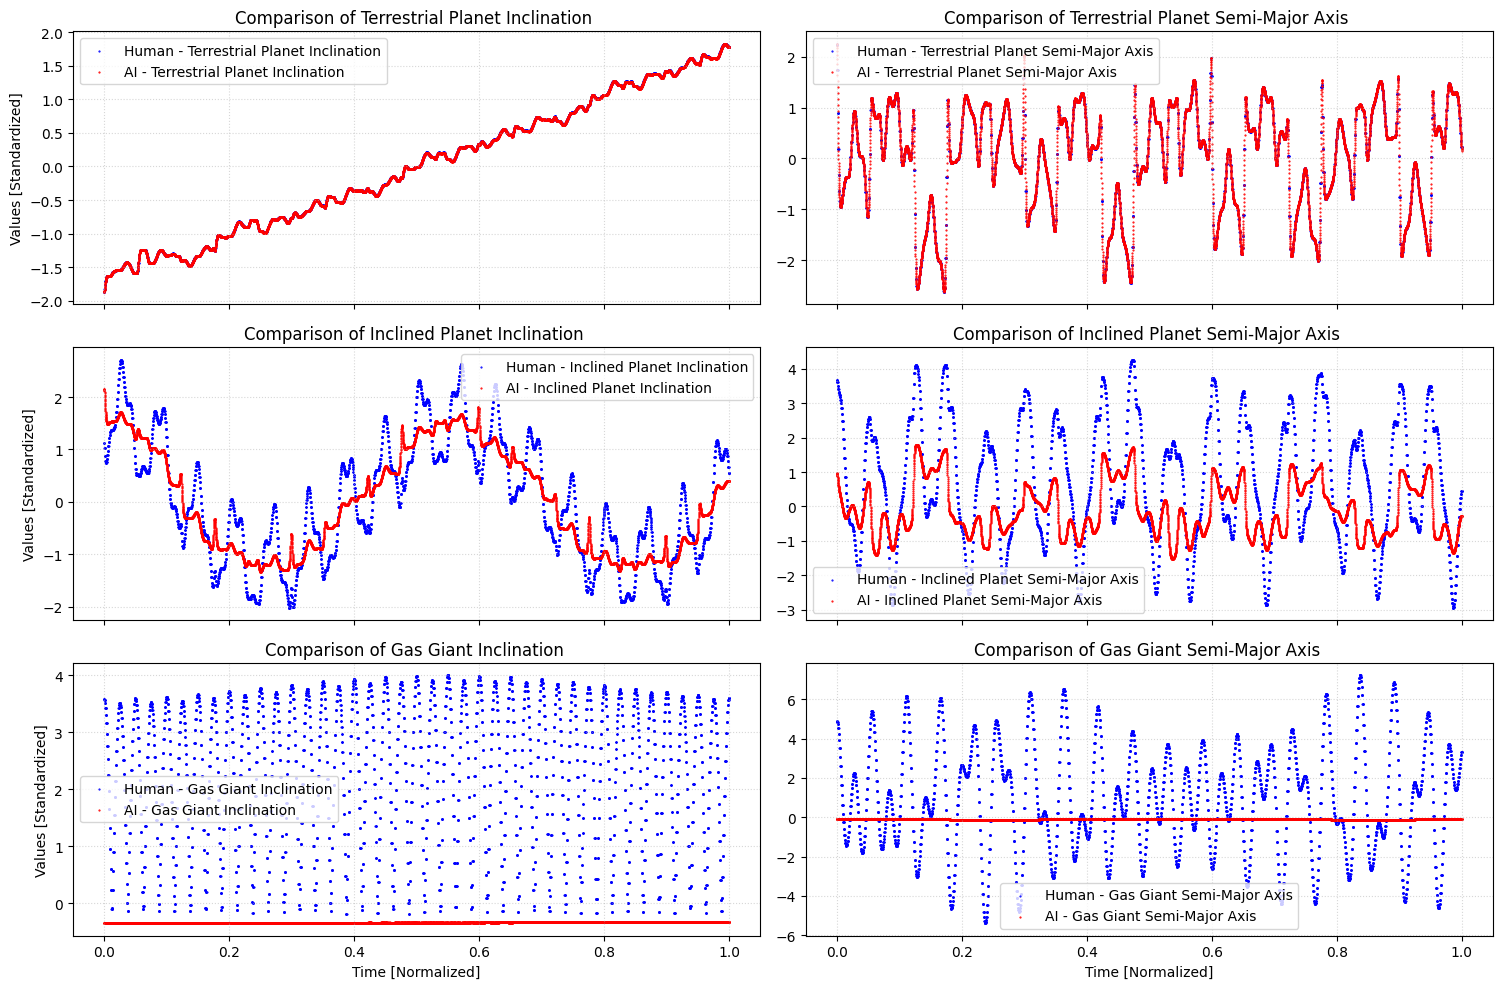

Root Mean Squared Value is: 

Terrestrial Planet Inclination        0.004014
Terrestrial Planet Semi-Major Axis    0.050456
Inclined Planet Inclination           0.581019
Inclined Planet Semi-Major Axis       1.776337
Gas Giant Inclination                 2.915611
Gas Giant Semi-Major Axis             2.899976
dtype: float64

Total RMSE: 1.170997657708678


In [32]:
# We Now apply the pipeline
# Import our reference data
import csv
import matplotlib.pyplot as plt

ref_time = []

# Get time data by reading csv file 'Inclined_Orbit_Data(75degrees_time).csv'
with open('Inclined_Orbit_Data(75degrees_time).csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Convert the string values in the row to floats
        convert_number = [float(i) for i in row]
        ref_time.append(convert_number)
    # Extract the first row as the time data
    ref_time = ref_time[0]

# Get quantities data by reading csv file 'Inclined_Orbit_Data(75degrees_quantities).csv'
with open('Inclined_Orbit_Data(75degrees_quantities).csv', 'r', newline='') as f:
    reader = csv.DictReader(f)
    ref_data = next(reader)
      
    # Have to turn string representation of an array back to a regular array for each key
    for key, value in ref_data.items():
        ref_data[key] = eval(value)  # Use eval() to convert string to array

# Apply the time series function to scale and normalize the data
ref_data, ai_data = time_series(ref_data, ref_time, quantities, times, True, True)

# Next, we interpolate the ai_data with the reference solutions 
# to ensure proper matching of data values for comparison:
ref_data, ai_data = interpolate_data(ref_data, ai_data) 

def graph():
    """
    Generates a graph comparing the reference and AI-generated data for each orbital element.
    """
    fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
    # Initialize a counter for plot index
    plot_index = 0
    for col in ref_data.columns:
        if col == 'Time':
            continue
        row = plot_index // 2
        col_num = plot_index % 2
    
        # Scatter plot for human (reference) data
        axs[row, col_num].scatter(ref_data['Time'], ref_data[col], label='Human - ' + col, c='blue', s=0.3)
        # Scatter plot for AI data
        axs[row, col_num].scatter(ai_data['Time'], ai_data[col], label='AI - ' + col, c='red', s=0.3)
        
        # Add grid, legend, and title
        axs[row, col_num].grid(alpha=0.5, linestyle='dotted')
        axs[row, col_num].legend()
        axs[row, col_num].set_title(f'Comparison of {col} ')
        
        # Set y-axis label for left subplots
        if col_num == 0:
            axs[row, col_num].set_ylabel('Values [Standardized]')
    
        # Set x-axis label for bottom subplots
        if row == 2:
            axs[row, col_num].set_xlabel('Time [Normalized]')
        
        # Increment the plot index
        plot_index += 1

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig("Human_AI_Comparison (Inclined Orbit 75degrees).png", dpi=300)
    plt.show()

graph() # This is optional (WARNING: This will save a png image of the graphs to your computer).

# Finally, we compare the values by using the Root Mean Squared Error between the two.
rmse = compute_score(ref_data, ai_data, tot_rmse=False)  # RMSE for each orbital element
rmse_total = compute_score(ref_data, ai_data, tot_rmse=True)  # Total RMSE

# Print Results
print(f'Root Mean Squared Value is: \n\n{rmse}')
print(f'\nTotal RMSE: {rmse_total}')